Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from KaggleAux import predict as ka 


In [3]:
from scipy import stats
# These are the plotting modules adn libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# These are the plotting modules adn libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Data Handling
Let's read our data in using pandas:

In [4]:
dframe = pd.read_csv('train.csv')


Show an overview of our data:

In [6]:
dframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Data Exploration

In [5]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


From the table above, we can note a few things. First of all, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them. Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.

# All good data analysis projects begin with trying to answer questions. Now that we know what column category data we have let's think of some questions or insights we would like to obtain from the data. So here's a list of questions we'll try to answer using our new data analysis skills!


1.) Who were the passengers on the Titanic? (Ages,Gender,Class,..etc)
2.) What deck were the passengers on and how does that relate to their class?
3.) Where did the passengers come from?
4.) Who was alone and who was with family?
5.) What factors helped someone survive the sinking?

Let's take a Look at our data graphically:

# So let's start with the first question: Who were the passengers on the titanic?

C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


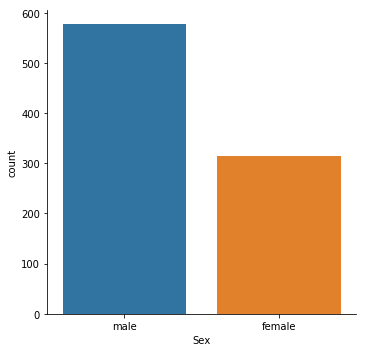

In [13]:
# Let's first check gender
sns.factorplot('Sex',data=dframe,kind='count')

C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


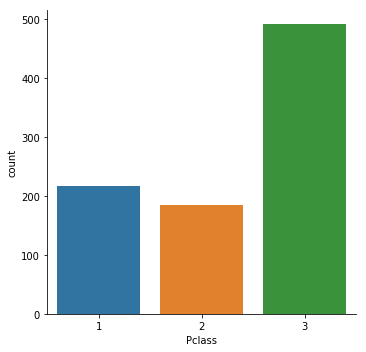

In [14]:

sns.factorplot('Pclass',data=dframe,kind='count')

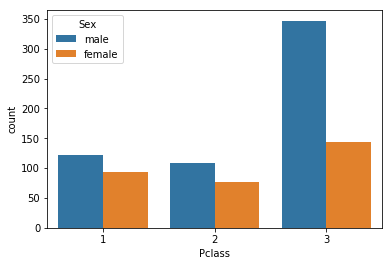

In [16]:
 # Now let's seperate the genders by classes, remember we can use the 'hue' arguement here!
sns.countplot('Pclass',data=dframe,hue='Sex')

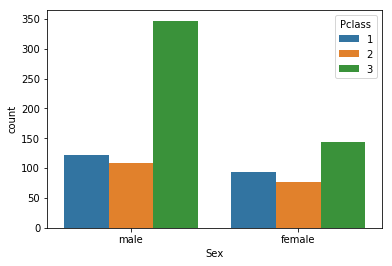

In [17]:
sns.countplot('Sex',data=dframe,hue='Pclass')

Wow, quite a few more males in the 3rd class than females, an interesting find. However, it might be useful to know the split between males,females,and children. How can we go about this?

In [6]:
# We'll treat anyone as under 16 as a child, and then use the apply technique with a function to create a new column

# Revisit Lecture 45 for a refresher on how to do this.

# First let's make a function to sort through the sex 
def mfc(passager):
    age,sex = passager
    if age < 16:
        return 'child'
    else:
        return sex
# We'll define a new column called 'person', remember to specify axis=1 for columns and not index
dframe['person']= dframe[['Age','Sex']].apply(mfc,axis=1)

In [23]:
# Let's see if this worked, check out the first eleven rows
dframe[0:11]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,male
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,child


Excellent! Now we have seperated the passengers between female,male,and child. This will be important later on beacuse of the famous "Women and children first policy"!

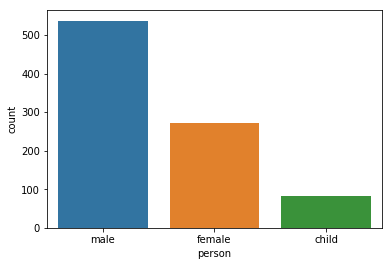

In [7]:
sns.countplot('person',data=dframe)

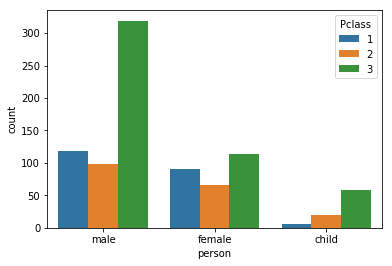

In [8]:
sns.countplot('person',data=dframe,hue='Pclass')

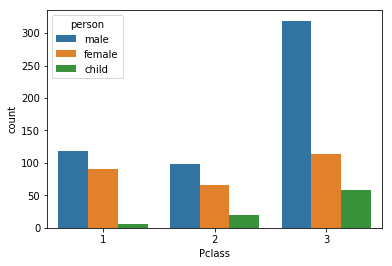

In [27]:
sns.countplot('Pclass',data=dframe,hue='person')

Interesting, quite a bit of children in 3rd class and not so many in 1st! How about we create a distribution of the ages to get a more precise picture of the who the passengers were.

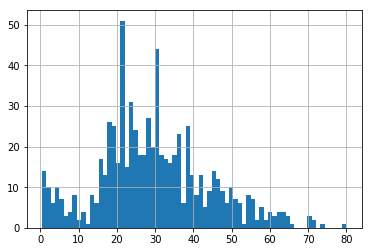

In [9]:
dframe['Age'].hist(bins=70)

In [29]:
dframe['Age'].mean()

29.69911764705882

In [31]:
# We could also get a quick overall comparison of male,female,child
dframe['person'].value_counts()

male      537
female    271
child      83
Name: person, dtype: int64

C:\Users\yangxuehan\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


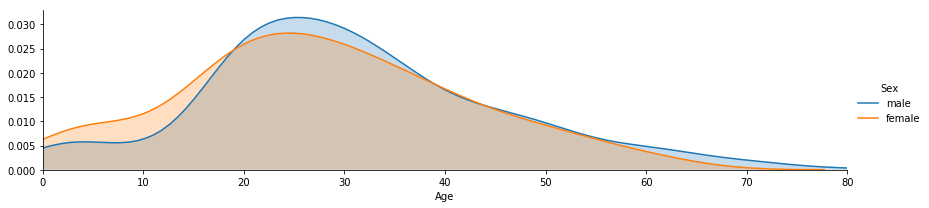

In [10]:
# Another way to visualize the data is to use FacetGrid to plot multiple kedplots on one plot

# Set the figure equal to a facetgrid with the pandas dataframe as its data source, set the hue, and change the aspect ratio.
fig = sns.FacetGrid(dframe, hue="Sex",aspect=4)

# Next use map to plot all the possible kdeplots for the 'Age' column by the hue choice
fig.map(sns.kdeplot,'Age',shade= True)

# Set the x max limit by the oldest passenger
oldest = dframe['Age'].max()

#Since we know no one can be negative years old set the x lower limit at 0
fig.set(xlim=(0,oldest))

#Finally add a legend
fig.add_legend()

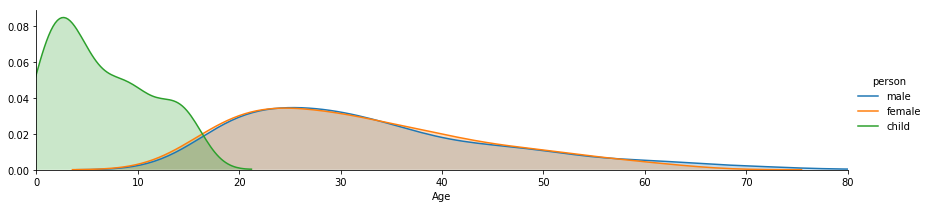

In [11]:
# Another way to visualize the data is to use FacetGrid to plot multiple kedplots on one plot

# Set the figure equal to a facetgrid with the pandas dataframe as its data source, set the hue, and change the aspect ratio.
fig = sns.FacetGrid(dframe, hue="person",aspect=4)

# Next use map to plot all the possible kdeplots for the 'Age' column by the hue choice
fig.map(sns.kdeplot,'Age',shade= True)

# Set the x max limit by the oldest passenger
oldest = dframe['Age'].max()

#Since we know no one can be negative years old set the x lower limit at 0
fig.set(xlim=(0,oldest))

#Finally add a legend
fig.add_legend()

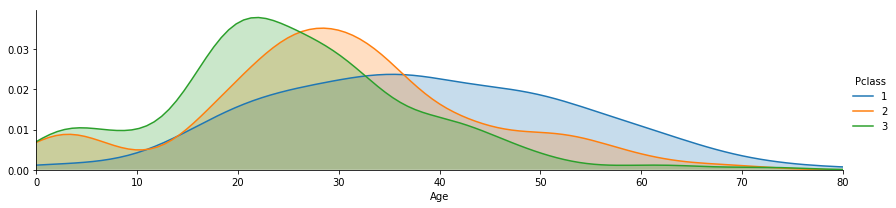

In [12]:
# Another way to visualize the data is to use FacetGrid to plot multiple kedplots on one plot

# Set the figure equal to a facetgrid with the pandas dataframe as its data source, set the hue, and change the aspect ratio.
fig = sns.FacetGrid(dframe, hue="Pclass",aspect=4)

# Next use map to plot all the possible kdeplots for the 'Age' column by the hue choice
fig.map(sns.kdeplot,'Age',shade= True)

# Set the x max limit by the oldest passenger
oldest = dframe['Age'].max()

#Since we know no one can be negative years old set the x lower limit at 0
fig.set(xlim=(0,oldest))

#Finally add a legend
fig.add_legend()

# We've gotten a pretty good picture of who the passengers were based on Sex, Age, and Class. So let's move on to our 2nd question: What deck were the passengers on and how does that relate to their class?

In [13]:
deck=dframe['Cabin'].dropna()

In [14]:
deck.head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

Notice we only need the first letter of the deck to classify its level (e.g. A,B,C,D,E,F,G)

C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


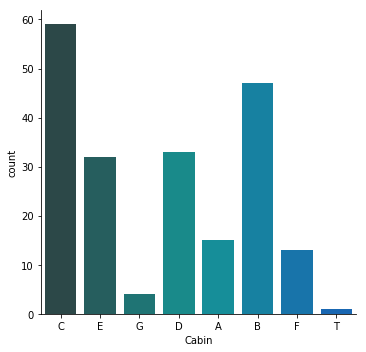

In [15]:
# So let's grab that letter for the deck level with a simple for loop

# Set empty list
levels = []
# Loop to grab first letter
for level in deck:
    levels.append(level[0])
# Reset DataFrame and use factor plot
cabin_df= DataFrame(levels)
cabin_df.columns=['Cabin']
sns.factorplot('Cabin',data=cabin_df,palette='winter_d',kind='count')

Interesting to note we have a 'T' deck value there which doesn't make sense, we can drop it out with the following code:

C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


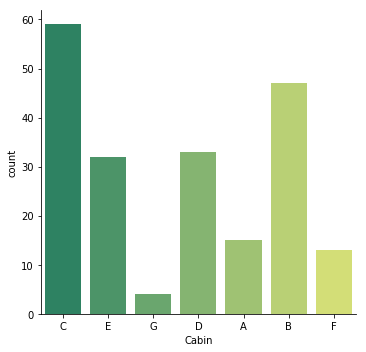

In [41]:
cabin_df= cabin_df[cabin_df.Cabin !='T']
sns.factorplot('Cabin',data=cabin_df,palette='summer',kind='count')

# Great now that we've analyzed the distribution by decks, let's go ahead and answer our third question: Where did the passengers come from?

In [16]:
# Let's take another look at our original data
dframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male


C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


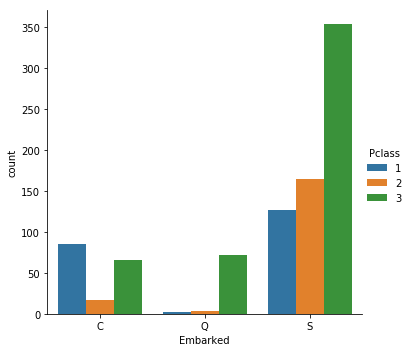

In [17]:
# Now we can make a quick factorplot to check out the results, note the x_order argument, used to deal with NaN values
sns.factorplot('Embarked',kind='count',data=dframe, hue='Pclass', order=['C','Q','S'])

Note here that the Embarked column has C,Q,and S values. Reading about the project on Kaggle you'll note that these stand for Cherbourg, Queenstown, Southhampton.

# An interesting find here is that in Queenstown, almost all the passengers that boarded there were 3rd class. It would be intersting to look at the economics of that town in that time period for further investigation. Now let's take a look at the 4th question: 4.) Who was alone and who was with family?

In [18]:

# Let's start by adding a new column to define alone

# We'll add the parent/child column with the sibsp column
dframe['Alone'] =  dframe.Parch + dframe.SibSp
dframe['Alone']

0       1
1       1
2       0
3       1
4       0
5       0
6       0
7       4
8       2
9       1
10      2
11      0
12      0
13      6
14      0
15      0
16      5
17      0
18      1
19      0
20      0
21      0
22      0
23      0
24      4
25      6
26      0
27      5
28      0
29      0
       ..
861     1
862     0
863    10
864     0
865     0
866     1
867     0
868     0
869     2
870     0
871     2
872     0
873     0
874     1
875     0
876     0
877     0
878     0
879     1
880     1
881     0
882     0
883     0
884     0
885     5
886     0
887     0
888     3
889     0
890     0
Name: Alone, Length: 891, dtype: int64

Now we know that if the Alone column is anything but 0, then the passenger had family aboard and wasn't alone. So let's change the column now so that if the value is greater than 0, we know the passenger was with his/her family, otherwise they were alone.

In [19]:
# Look for >0 or ==0 to set alone status
dframe['Alone'].loc[dframe['Alone'] >0] = 'Family'
dframe['Alone'].loc[dframe['Alone'] == 0] = 'alone'

C:\Users\yangxuehan\Anaconda2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
# Let's check to make sure it worked
dframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,person,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male,Family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,Family
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female,alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,Family
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male,alone


C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


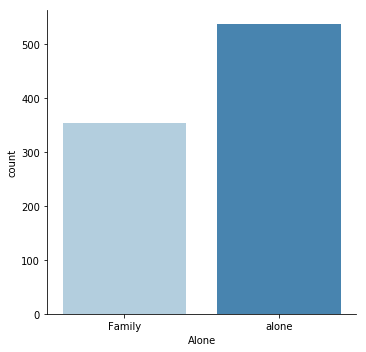

In [21]:
# Now let's get a simple visualization!
sns.factorplot('Alone',data=dframe,palette='Blues',kind='count')

Great work! Now that we've throughly analyzed the data let's go ahead and take a look at the most interesting (and open-ended) question: What factors helped someone survive the sinking?

C:\Users\yangxuehan\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


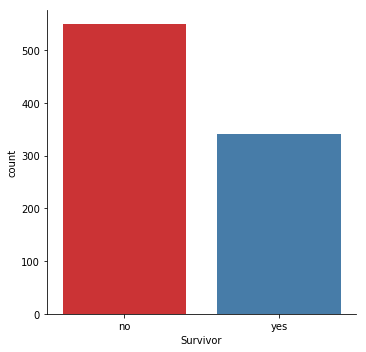

In [32]:
# Let's start by creating a new column for legibility purposes through mapping (Lec 36)
dframe["Survivor"] = dframe.Survived.map({0: "no", 1: "yes"})

# Let's just get a quick overall view of survied vs died. 
sns.factorplot('Survivor',data=dframe,palette='Set1',kind='count')

So quite a few more people died than those who survived. Let's see if the class of the passengers had an effect on their survival rate, since the movie Titanic popularized the notion that the 3rd class passengers did not do as well as their 1st and 2nd class counterparts.

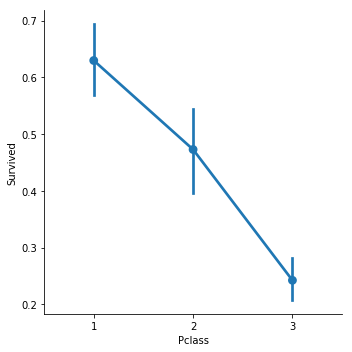

In [39]:
sns.catplot( 'Pclass','Survived',data=dframe,kind='point')


Look like survival rates for the 3rd class are substantially lower! But maybe this effect is being caused by the large amount of men in the 3rd class in combination with the women and children first policy. Let's use 'hue' to get a clearer picture on this.

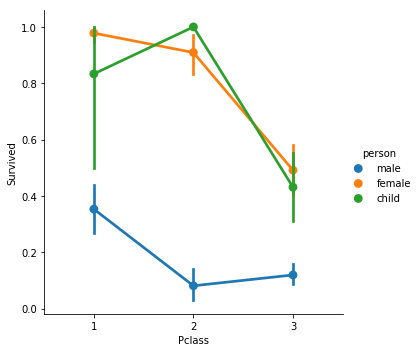

In [40]:
sns.catplot( 'Pclass','Survived',data=dframe,hue='person',kind='point')
#From this data it looks like being a male or being in 3rd class were both not favourable for survival. 
#Even regardless of class the result of being a male in any class dramatically decreases your chances of survival.

From this data it looks like being a male or being in 3rd class were both not favourable for survival. Even regardless of class the result of being a male in any class dramatically decreases your chances of survival.

But what about age? Did being younger or older have an effect on survival rate?

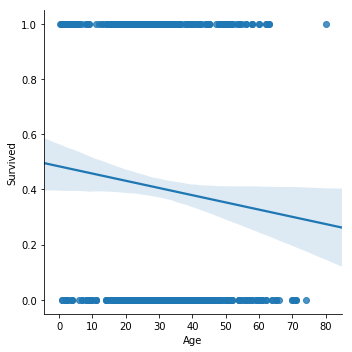

In [41]:
# Let's use a linear plot on age versus survival
sns.lmplot('Age','Survived',data=dframe)


Looks like there is a general trend that the older the passenger was, the less likely they survived. Let's go ahead and use hue to take a look at the effect of class and age.

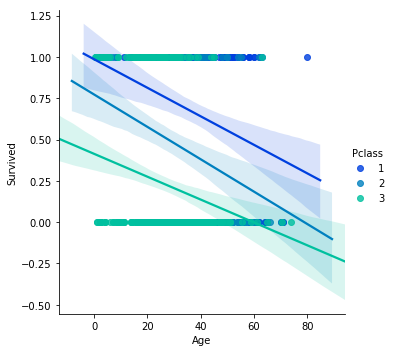

In [42]:
sns.lmplot('Age','Survived',hue='Pclass',data=dframe,palette='winter')

We can also use the x_bin argument to clean up this figure and grab the data and bin it by age with a std attached!

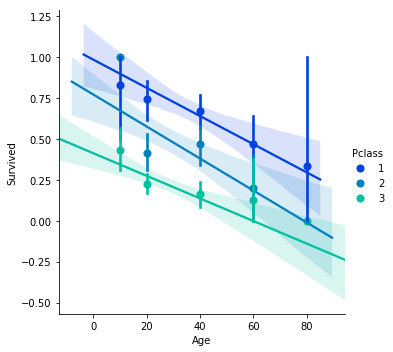

In [43]:
# Let's use a linear plot on age versus survival using hue for class seperation
generations=[10,20,40,60,80]
sns.lmplot('Age','Survived',hue='Pclass',data=dframe,palette='winter',x_bins=generations)
# Interesting find on the older 1st class passengers! What about if we relate gender and age with the survival set

Interesting find on the older 1st class passengers! What about if we relate gender and age with the survival set?

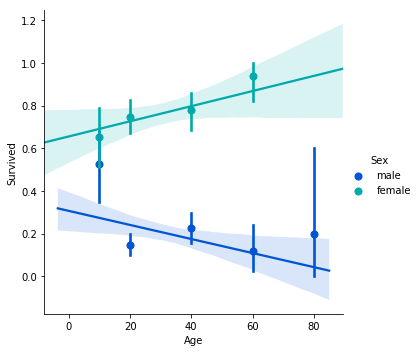

In [44]:
sns.lmplot('Age','Survived',hue='Sex',data=dframe,palette='winter',x_bins=generations)